Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Local directory
data_dir = '../datasets/climate'
file_name = 'temp_anom_w_forcing'
file_path = f'{data_dir}/{file_name}.csv'

In [4]:
dataset = pd.read_csv(file_path)

In [5]:
dataset.shape

(163, 11)

In [6]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [7]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [8]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


Define the required time and target columns

In [9]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [10]:
# dataset[target_col] = dataset[target_col].astype(float)

In [11]:
# dataset.head()

Split dataset into train and test sets

In [12]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

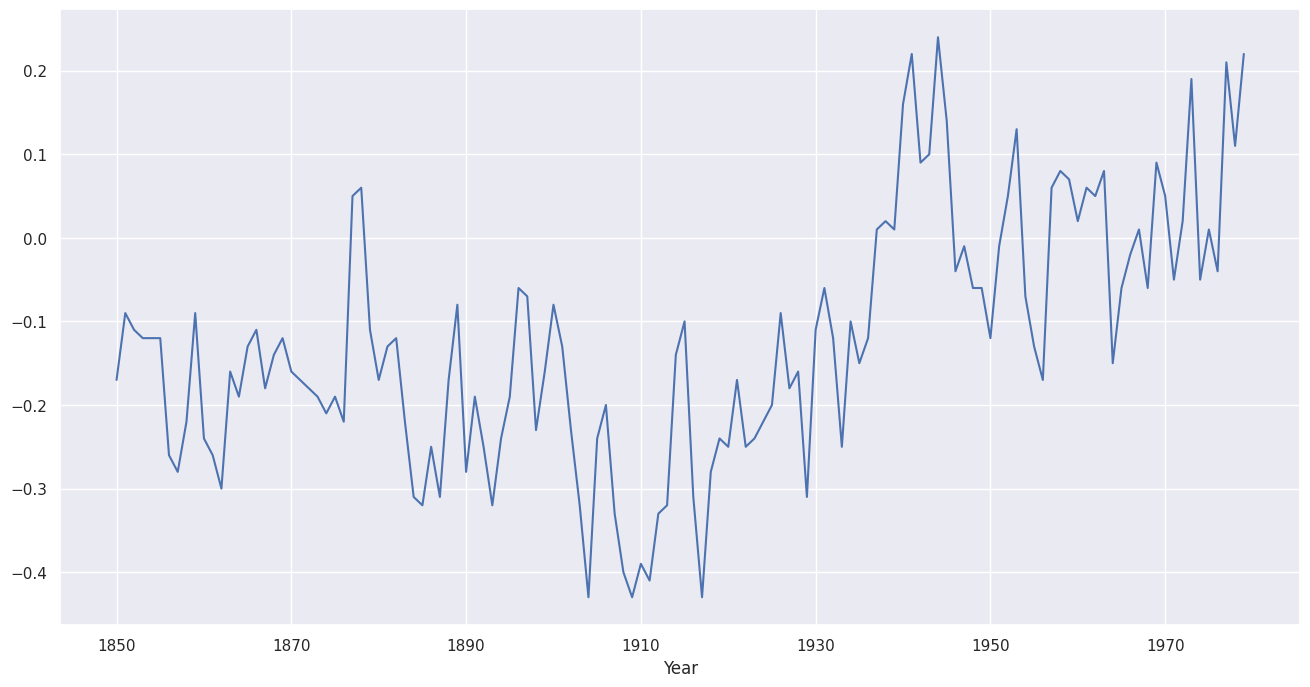

In [13]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [14]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [16]:
# Default model request
# model_request = {
#     'type': 'meta_lr',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autoets'},
#         ],
#     },
# }

# Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# np_external_model_request = None

# Deep SYBIL customized model request
ds_external_model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            # {'type': 'dartsimputer'},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            {'type': 'darts_tcn',
             'params': {
                 'output_chunk_length': 24,
                 'input_chunk_length': 48,                 
                 'n_epochs': 100,
            }},
            #     {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            # {'type': 'darts_tsmixer'},            
            # {'type': 'darts_dlinear'},
            #  {'type': 'darts_blockrnn'},
            #  {'type': 'darts_tcn'},
            # {'type': 'darts_tsmixer'},
            # {'type': 'darts_tide'}
        ],
    },
}
ds_external_model_request = None

# Customized model request
model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer'},
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_naive'},
            # {'type': 'darts_seasonalnaive'},
            # {'type': 'darts_autotheta'},
            # {'type': 'stats_autotheta'},
            # {'type': 'darts_autoets'},
            # {'type': 'stats_autoets'},
            # {'type': 'darts_autoarima'},
            # {'type': 'stats_autoarima'},
            # {'type': 'darts_autoces'},
            # {'type': 'darts_kalman'},
            # {'type': 'darts_catboost'},            
            # {'type': 'darts_tbats'},
            # {'type': 'darts_linearregression'},
            # {'type': 'darts_lightgbm',
            #  'params': {
            #      'lags': 12,
            #      'output_chunk_length': 6,
            #      'verbose': -1
            # }}
            # {'type': 'neuralprophet',
            #  'external_params': np_external_model_request
            # }  # Onboard NeuralProphet external service
            {'type': 'deepsybil',
             'external_params': ds_external_model_request
            }  # Deep SYBIL external service
        ],
    },
}

This is for JSON model_request

In [17]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [18]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

Train API JSON Payload

In [19]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [20]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [21]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [22]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [23]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [500]>

CPU times: user 3.51 ms, sys: 479 µs, total: 3.99 ms
Wall time: 18.5 ms


In [24]:
train_json_out = response.json()  # dict output
train_json_out

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [70]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [71]:
test_data[:2]

[['1980',
  2.09837,
  0.362496,
  0.132923,
  -0.197799,
  0.0534377,
  0.00195668,
  -0.116014,
  -0.557516,
  -0.0294989],
 ['1981',
  2.15487,
  0.37198,
  0.13994,
  -0.198391,
  0.0534899,
  0.00196222,
  -0.12073,
  -0.572096,
  -0.0378411]]

Model from Train API

In [72]:
model = train_json_out['model']

Forecast API JSON Payload

In [73]:
api_json = {
    'model': model,
    'data': test_data
}

Build URL (same as train except for the endpoint)

In [74]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [75]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: total: 15.6 ms
Wall time: 3.99 s


In [76]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1980', 0.1779299119227869],
  ['1981', 0.1522141532749593],
  ['1982', 0.17671657300894422],
  ['1983', 0.1984270649682624],
  ['1984', 0.17854445132601987],
  ['1985', 0.17227072079285505],
  ['1986', 0.17351427067650554],
  ['1987', 0.15189969086689942],
  ['1988', 0.17488685568172052],
  ['1989', 0.19430049394154897],
  ['1990', 0.17751613988320286],
  ['1991', 0.1731339659815831],
  ['1992', 0.1736431316209091],
  ['1993', 0.15208370317222947],
  ['1994', 0.17477750699611677],
  ['1995', 0.19411185529487934],
  ['1996', 0.17779669922900837],
  ['1997', 0.17363549111301407],
  ['1998', 0.17371014332459928],
  ['1999', 0.152108964584788],
  ['2000', 0.17478454832108198],
  ['2001', 0.19413836695672643],
  ['2002', 0.17781830184283437],
  ['2003', 0.1736588747870828],
  ['2004', 0.17371251197653564],
  ['2005', 0.1521085420853468],
  ['2006', 0.17478540648235324],
  ['2007', 0.1712390666716868],
  ['2008', 0.15128856864334378],
  ['2009', 0.17270111514204384],
  ['2010', 0

Combine forecast dates and output

In [77]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [78]:
forecast_df.shape

(33, 2)

In [79]:
forecast_df.columns

Index(['Year', 'Anomaly'], dtype='object')

In [80]:
forecast_df.head()

,Year,Anomaly
0,1980,0.177930
1,1981,0.152214
2,1982,0.176717
3,1983,0.198427
4,1984,0.178544


In [81]:
forecast_df.tail()

,Year,Anomaly
28,2008,0.151289
29,2009,0.172701
30,2010,0.191950
31,2011,0.176901
32,2012,0.174307


Plot train and forecast side-by-side

C:\Users\saira\AppData\Local\Temp\ipykernel_21880\2998340865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


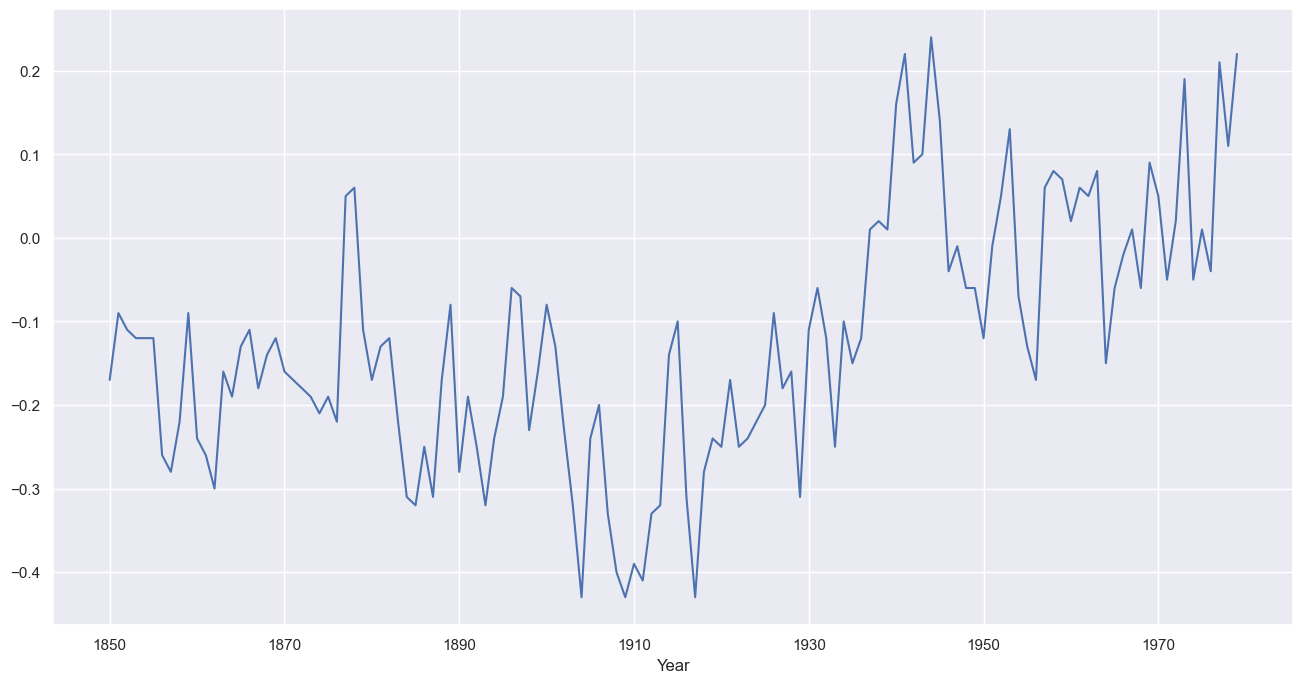

In [82]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

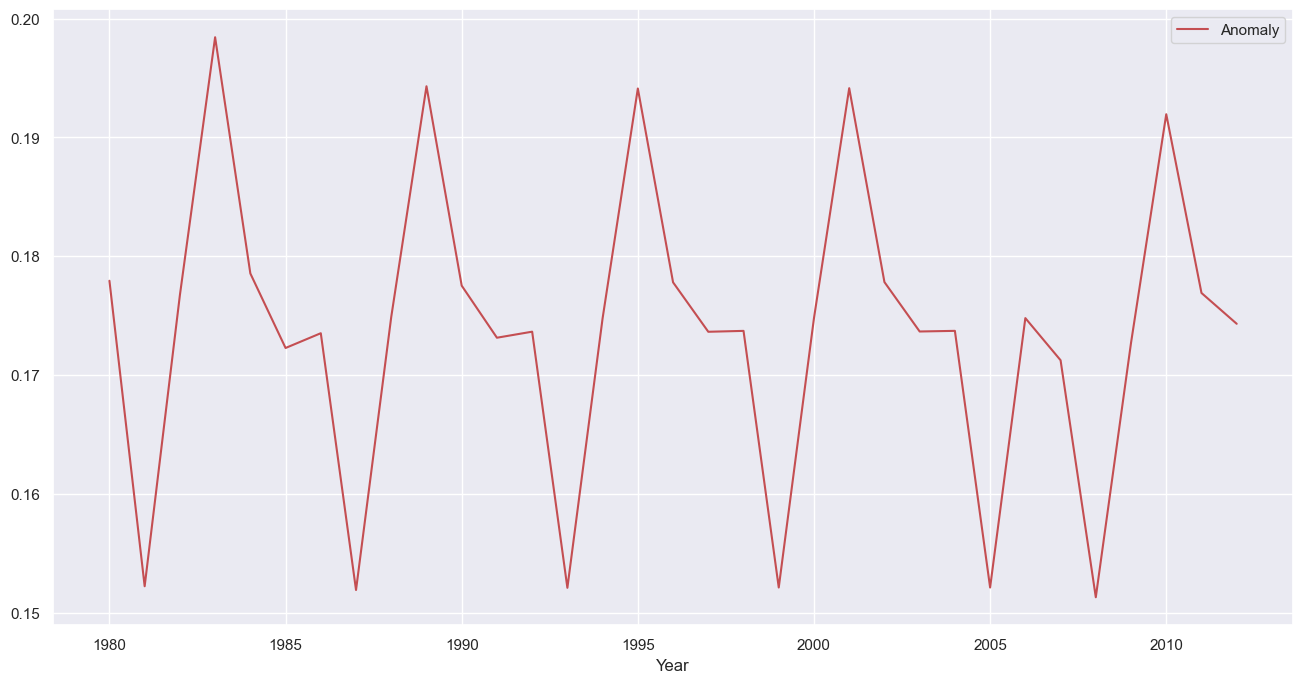

In [83]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [84]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [85]:
df.shape

(163, 12)

In [86]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [87]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
158,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151289,r
159,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.172701,r
160,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.191950,r
161,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176901,r
162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.174307,r


Plot combined train and forecast sets with the vertical black line as the cut-off

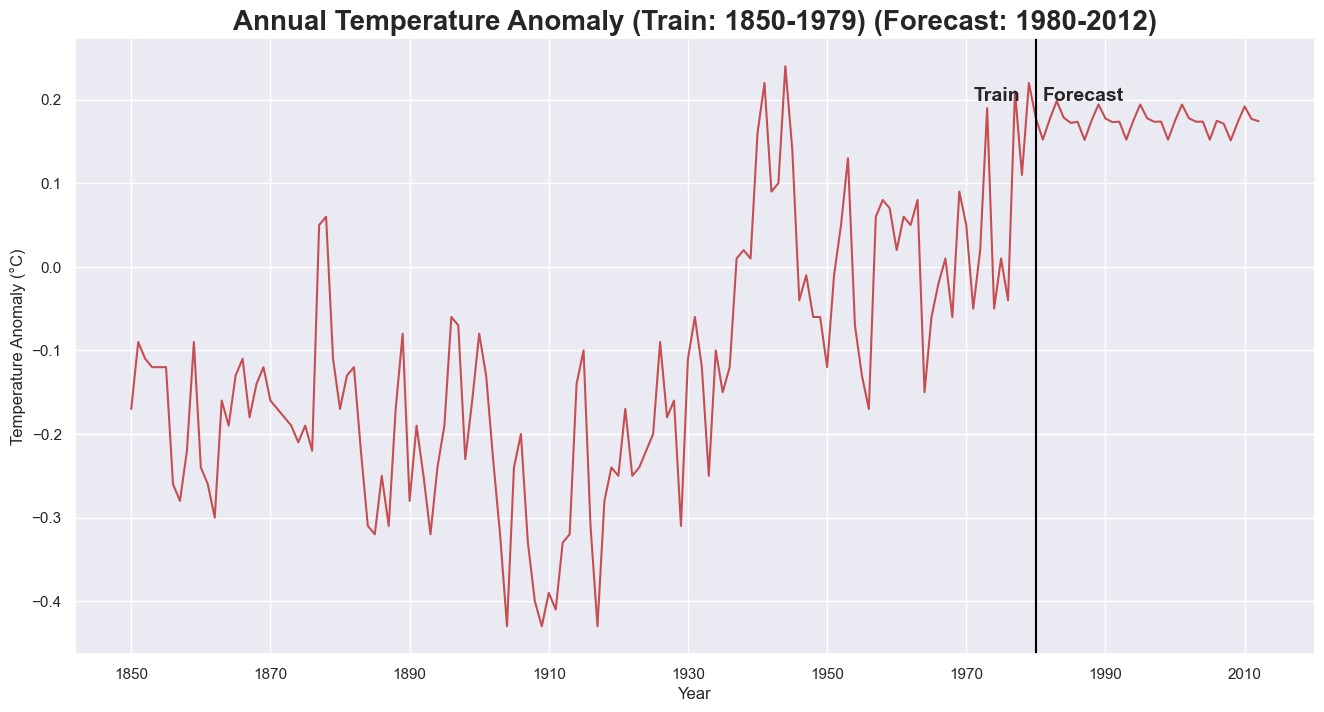

In [88]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Forecast: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset to compare

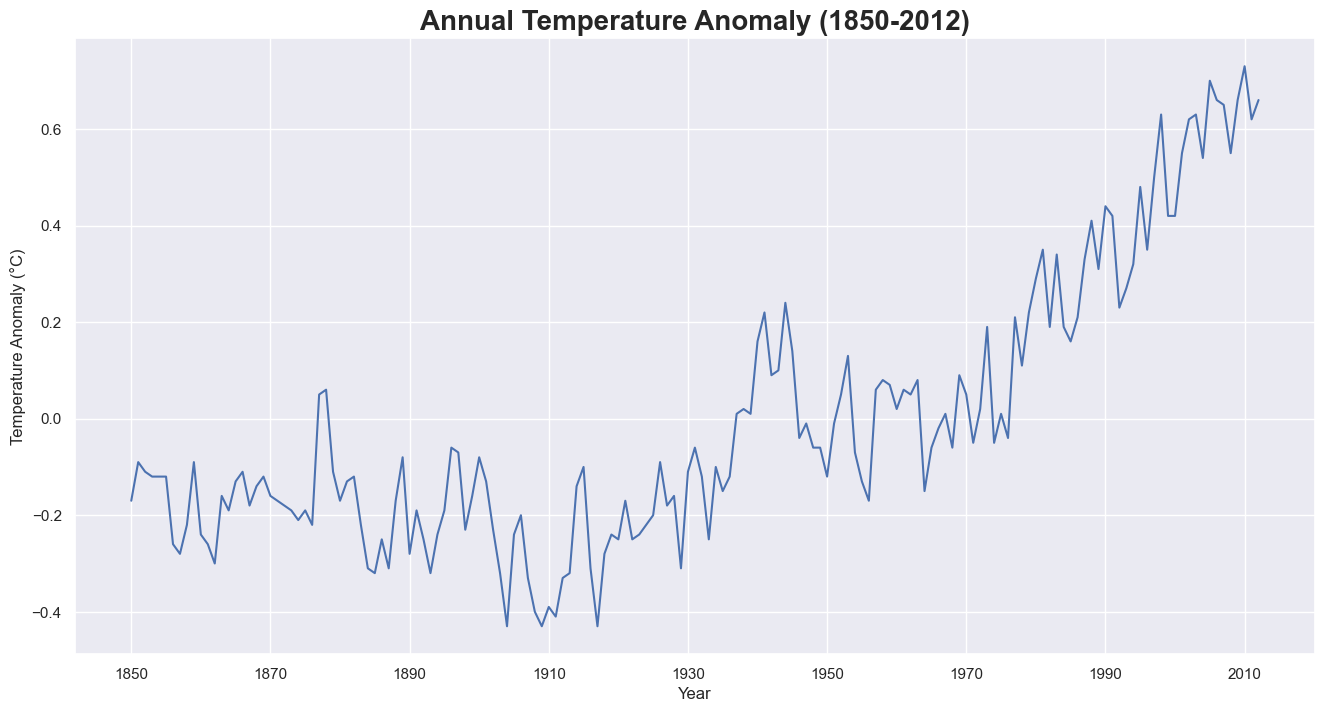

In [89]:
figsize = (16, 8)
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (1850-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset (blue) with SYBIL forecasted values (red)

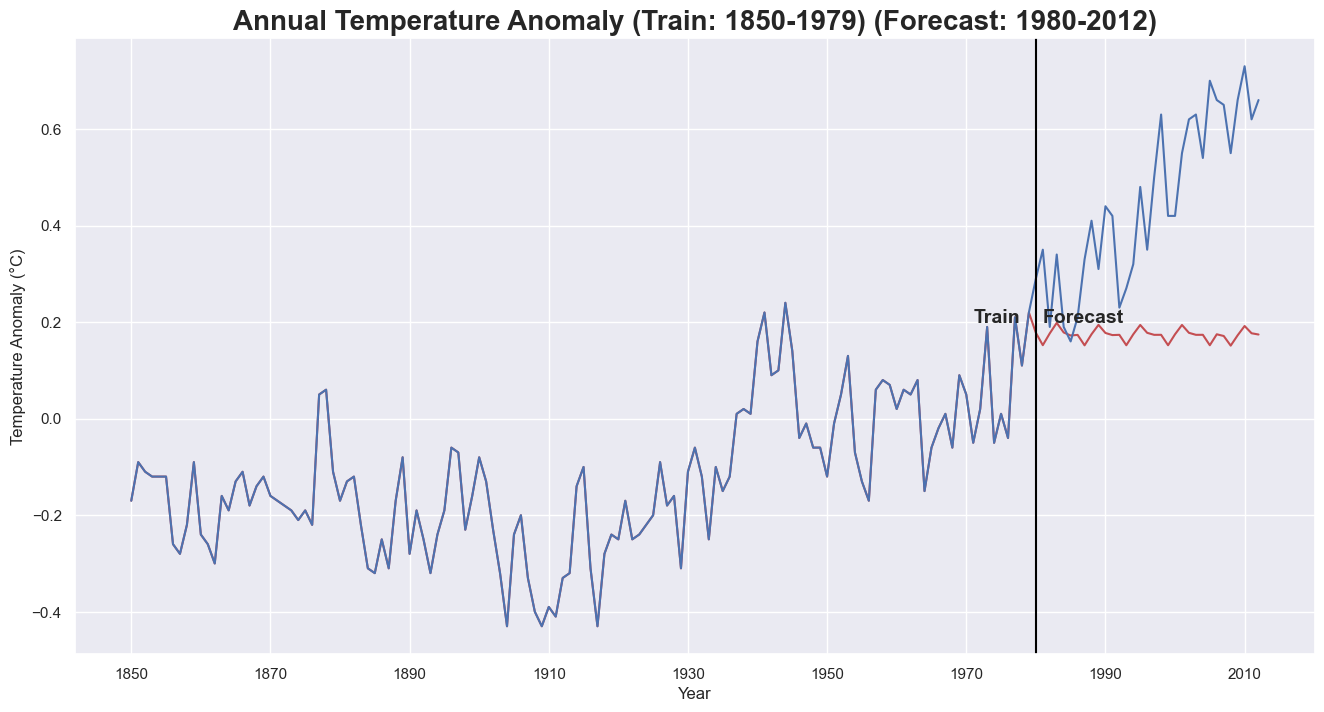

In [90]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Forecast: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();